# Technical write-up+code

## Methods

I used a decision tree algorithm to predict what income group a given economy is from based on record mental health data.

In general, a a decision Trees (DT) are a type of model used in machine learning that mimic human decision-making processes. Imagine you're trying to decide what to wear. You might look at the weather (a feature) and choose accordingly. A decision tree does something similar with data: it makes a series of choices based on the features to reach a conclusion, like deciding if an email is spam. It's like a flowchart – starting with a question about the data, it branches out until it reaches an answer.

Random Forests (RF) build on decision trees. If a decision tree is like a single advisor making a decision, a random forest is like a committee. It creates multiple decision trees, each with slightly different perspectives, and then combines their votes to make a final decision. This helps in getting a more balanced and less biased result, as it avoids over-relying on a single perspective.


## Class distribution

Physical health    0.537634
Mental health      0.462366
Name: Label, dtype: float64


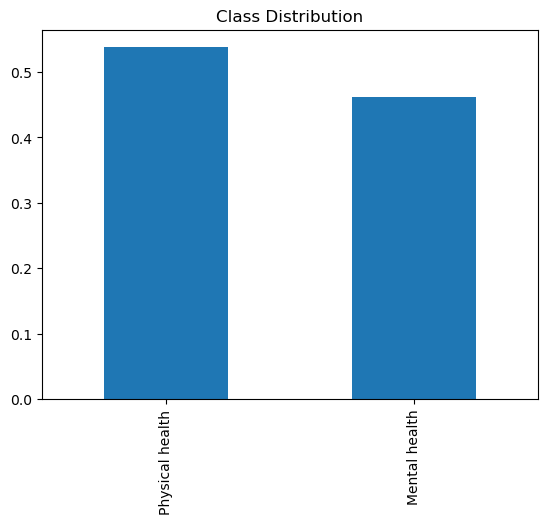

In [232]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Load the dataset
df = pd.read_csv('./Data/symptoms.csv')
df.columns

# print(df.columns)
# Compute the distribution of class labels
class_distribution = df['Label'].value_counts(normalize=True)

# Output the distribution
print(class_distribution)

# Visualize the distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.show()

## Baseline model for comparison
To understand the accuracy of the model, I created a baseline model to compare it to. A baseline model in machine learning and data science serves as a simple, often basic reference point for comparing the performance of more complex models. 

In [233]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Prepare the data
X = df.drop('Label', axis=1)
y = df['Label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit a random classifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

# Evaluate the classifier
y_pred = dummy.predict(X_test)
print(classification_report(y_test, y_pred))


                 precision    recall  f1-score   support

  Mental health       0.50      0.41      0.45        22
Physical health       0.35      0.44      0.39        16

       accuracy                           0.42        38
      macro avg       0.42      0.42      0.42        38
   weighted avg       0.44      0.42      0.42        38



## Model tuning
Decision Trees:

   Tree_depth  train_accuracy_score  test_accuracy_score
0           1              0.763514             0.763158
1           2              0.844595             0.789474
2           3              0.912162             0.763158


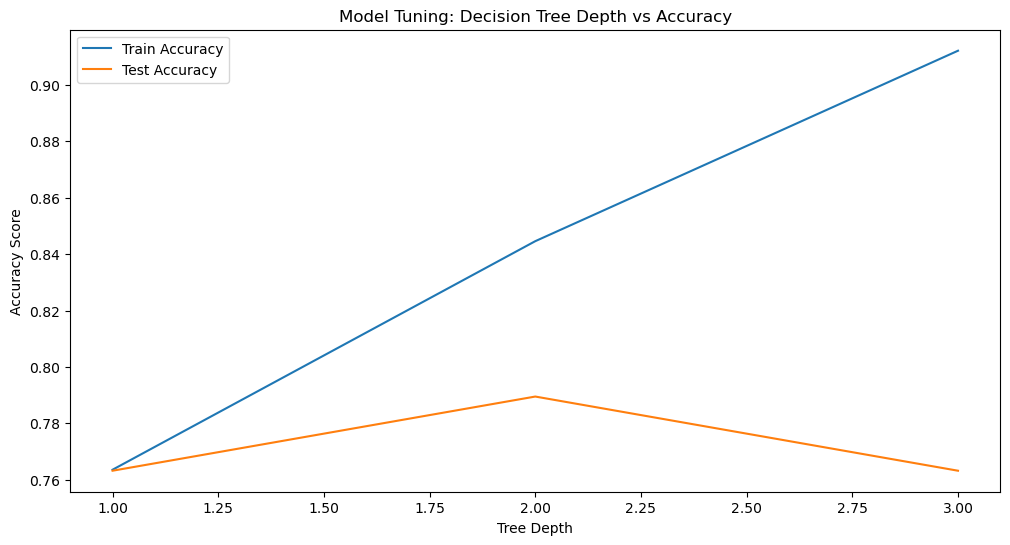

In [234]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load and preprocess your data
X = df['Symptoms']  # Replace with your text column name
y = df['Label']  # Replace with your label column name
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

test_results = []
train_results = []
#for num_layer in range(1, 30):
#for num_layer in range(1, 7):
for num_layer in range(1, 4):
    # Include TfidfVectorizer in the pipeline
    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier(max_depth=num_layer))
    ])
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    test_results.append([num_layer, accuracy_score(y_test, y_test_pred)])
    train_results.append([num_layer, accuracy_score(y_train, y_train_pred)])

# Create DataFrames for visualization
tuning_train_df = pd.DataFrame(train_results, columns=["Tree_depth", "train_accuracy_score"])
tuning_test_df = pd.DataFrame(test_results, columns=["Tree_depth", "test_accuracy_score"])
# print(tuning_train_df)
# print(tuning_test_df)
#merge two dataframes
tuning_df = pd.merge(tuning_train_df, tuning_test_df, on='Tree_depth')
print(tuning_df)
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(tuning_train_df['Tree_depth'], tuning_train_df['train_accuracy_score'], label='Train Accuracy')
plt.plot(tuning_test_df['Tree_depth'], tuning_test_df['test_accuracy_score'], label='Test Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy Score')
plt.title('Model Tuning: Decision Tree Depth vs Accuracy')
plt.legend()
plt.show()

Random Forests:

In [235]:
from sklearn.model_selection import GridSearchCV

# Set the parameters by cross-validation
tuned_parameters = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

# Create a new pipeline with a RandomForestClassifier
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Use GridSearchCV to tune the model
clf = GridSearchCV(model_rf, tuned_parameters, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

In [ ]:
# Set the best parameters in the RandomForestClassifier
best_params_rf = {
    'n_estimators': 800, 
    'max_depth': None,
    'min_samples_leaf': 1, 
    'min_samples_split': 10, 
    'max_features': 'log2'
}

# Create the pipeline with TfidfVectorizer and RandomForestClassifier with the best parameters
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(**best_params_rf, random_state=42))
])

# Train the model with the best parameters on the training data
model_rf.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred_rf = model_rf.predict(X_train)
y_test_pred_rf = model_rf.predict(X_test)

# Calculate the accuracy scores for the training and test sets
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

# Print the accuracy scores
print(f"Random Forest training accuracy with best parameters: {train_accuracy_rf * 100:.2f}%")
print(f"Random Forest testing accuracy with best parameters: {test_accuracy_rf * 100:.2f}%")


Random Forest training accuracy with best parameters: 99.32%
Random Forest testing accuracy with best parameters: 84.21%


In [ ]:
# print(model.named_steps['dt'].classes_)
# # The first element is what '0' represents, and the second element is what '1' represents.

## Final results
The decesion tree has an accurcay of 0.91 on the traning dataset and an accurcy of 0.76 on the test dataset when the num_layer is set to 3.

In fact, when I set my num_layer to 35 at first, but I found that the training accuracy has reached 100% for tree depths greater than or equal to 7, while the test accuracy remains significantly lower and does not improve. This is a sign of overfitting, the model has perfectly learned the training dataset, including its noise and outliers. The model becomes increasingly tailored to the training data, losing its ability to generalize to unseen data, therefore, I decided to set the num_layer to 6.  

Initially, as the tree depth increases from 1 to 2, there's an improvement in both training and testing accuracy. However, beyond a certain point (around a depth of 2 or 3), the increase in training accuracy does not translate to an improvement in testing accuracy. This suggests that the optimal tree depth for this model, where it balances learning from the training data without losing generalizability, might be around 2 or 3.

In summary, while a high training accuracy score may seem positive at first glance, it can be indicative of overfitting when it is not accompanied by a corresponding high test accuracy.

The random forest has an accurcay of 0.99 on the traning dataset and an accurcy of 0.84 on the test dataset when 'n_estimators': 800,'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'max_features': 'log2'

Below is the barplot and confusion matrix for the test dataset(Using decision tree):
For the Confusion matrix, Although the number of the testing set is limited, but we can still see the diagonal of the confusion matrix is dark blue whereas the other boxes are faintly colored, indicating that there is a high number of correct predictions.

Training dataset
Accuracy:  91.21621621621621
Number of mislabeled points:  13
Testing dataset
Accuracy:  73.68421052631578
Number of mislabeled points:  10


[Text(0.5, 1.0, 'Accuracy of model for training vs test sets')]

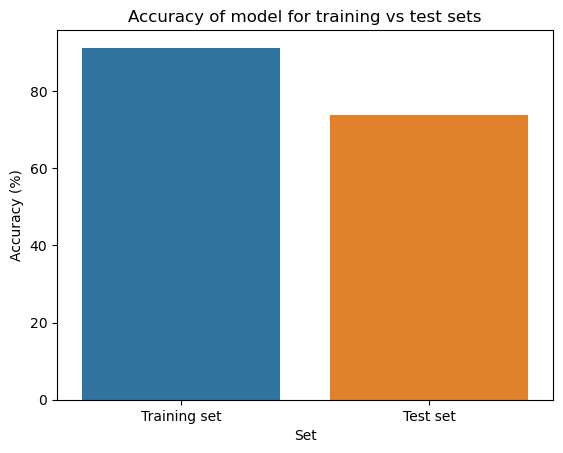

In [ ]:
# TEST ACCURACY

# Training dataset
print("Training dataset")
print("Accuracy: ", accuracy_score(y_train, y_train_pred) * 100) 
print("Number of mislabeled points: ", (y_train != y_train_pred).sum()) 

# Testing dataset
y_test_pred = model.predict(X_test)
print("Testing dataset")
print("Accuracy: ", accuracy_score(y_test, y_test_pred)*100) 
print("Number of mislabeled points: ", (y_test != y_test_pred).sum()) 

# Plot
model_accuracies = pd.DataFrame({'Set':['Training set','Test set'], 'Accuracy (%)': [accuracy_score(y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred)*100]})
sns.barplot(data=model_accuracies, x="Set", y="Accuracy (%)").set(title = 'Accuracy of model for training vs test sets' )

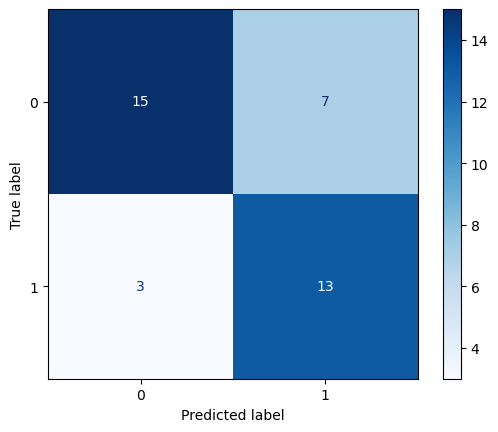

In [ ]:
# confusion matrix(test set)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))

# Plot using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

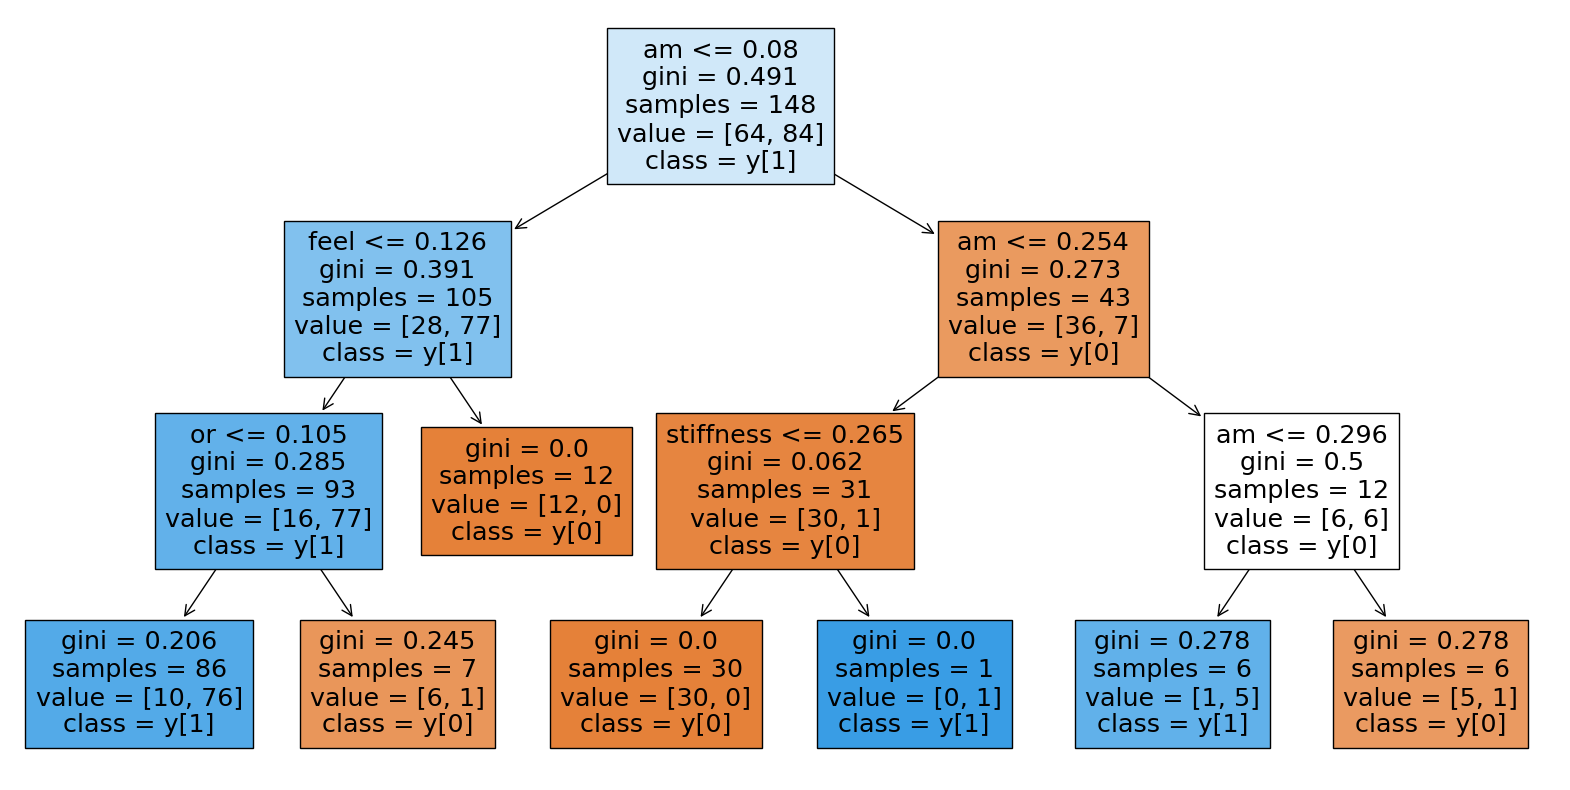

In [ ]:
#decesion tree visualization
from sklearn.tree import plot_tree

# Fit the model with desired tree depth(3)
desired_depth = 3
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier(max_depth=desired_depth))
])
model.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(model.named_steps['dt'], filled=True, feature_names=model.named_steps['tfidf'].get_feature_names_out(), class_names=True)
plt.show()

# Conclusions

In conclusion, I think this decision tree model is a high quality model because it has the relatively high accuracy scores for both training and test sets.

We can see how well a model can distinguish between health issues related to the mind, like anxiety or depression (mental health problems), and those related to the body, such as a broken arm or a cold (physical health). 

From the matrix, we see that when it is given symptoms and guesses they're related to mental health, it's correct 15 times but also makes a mistake 7 times, confusing physical symptoms for mental ones. Conversely, when it guesses symptoms are related to physical health, it's spot on 13 times, but it still slips up 3 times, mislabeling mental health symptoms as physical.

It matters because it's about getting the right help when we need it.  If we're feeling down, we don't want an app to suggest, what we need is just a good night's sleep or to relax. Similarly, if our body is aching because of an underlying physical condition, being advised to seek mental health support wouldn't be the most helpful first step; The hiccips here suggests it's still learning and needs more information to make better guesses(we may need more traning data and testing data), Perhaps it's not yet good at picking up on the subtleties that distinguish a cough from stress from a cough from a cold.

In the future, there's a lot we can do to get better at this. We can feed the model a wider variety of examples so it can learn the full range of symptoms for both mental and physical health issues. Or, we can get clever and help the model understand each person's unique health patterns over time, making its predictions more personalized and accurate.